In [ ]:
#| hide
#|eval: false
# This is to render Plotly plots into HTML
# For more information, see https://quarto.org/docs/interactive/widgets/jupyter.html#plotly
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import warnings
warnings.simplefilter('ignore')

import logging
logging.getLogger('mlforecast').setLevel(logging.ERROR)

# Machine Learning Models

> Machine Learning Models

- skip_showdoc: true
- skip_exec: true

In [ ]:
#| default_exp stats

To use `MLForecast` for time series forecasting, we instantiate a new `MLForecast` object and provide it with various parameters to tailor the modeling process to our specific needs:

- `models`: This parameter accepts a list of machine learning models you wish to use for forecasting. You can import your preferred models from scikit-learn, lightgbm and xgboost.

- `freq`: This is a string indicating the frequency of your data (hourly, daily, weekly, etc.). The specific format of this string should align with pandas' recognized frequency strings.

- `target_transforms`: These are transformations applied to the target variable before model training and after model prediction. This can be useful when working with data that may benefit from transformations, such as log-transforms for highly skewed data.

- `lags`: This parameter accepts specific lag values to be used as regressors. Lags represent how many steps back in time you want to look when creating features for your model. For example, if you want to use the previous day's data as a feature for predicting today's value, you would specify a lag of 1.

- `lags_transforms`: These are specific transformations for each lag. This allows you to apply transformations to your lagged features.

- `date_features`: This parameter specifies date-related features to be used as regressors. For instance, you might want to include the day of the week or the month as a feature in your model.

- `num_threads`: This parameter controls the number of threads to use for parallelizing feature creation, helping to speed up this process when working with large datasets.

All these settings are passed to the `MLForecast` constructor. Once the `MLForecast` object is initialized with these settings, we call its `fit` method and pass the historical data frame as the argument. The `fit` method trains the models on the provided historical data, readying them for future forecasting tasks.


## Data Extraction

In [ ]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Generate a sine wave for demonstration

In [ ]:
from tqdm.autonotebook import tqdm
from statsforecast import StatsForecast

from statsforecast.utils import AirPassengersDF, ConformalIntervals
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
cycles = 26
weeks = cycles * 2
resolution = 7


np.random.seed(0)
t = np.linspace(0, cycles * np.pi, weeks * resolution)

waveform = np.random.normal(scale=0.5, size=len(t)) + 0.5 * np.sign(np.sin(0.67 * t))
sine_wave = np.sin(t) + 0.3*np.sin(4.71*t) + waveform

In [ ]:
# Create a Pandas DataFrame
df = pd.DataFrame({'y': sine_wave})
df['unique_id'] = 1

In [ ]:
rng = pd.date_range('04/01/2021', periods=df.shape[0], freq='D')
df['ds'] = rng
df

,y,unique_id,ds
0,0.882026,1,2021-04-01
1,1.184884,1,2021-04-02
2,1.680301,1,2021-04-03
3,2.234016,1,2021-04-04
4,1.950096,1,2021-04-05
...,...,...,...
359,-1.075326,1,2022-03-26
360,-1.071706,1,2022-03-27
361,-1.120472,1,2022-03-28
362,-0.144448,1,2022-03-29


In [ ]:
df_plot = df.copy()
df_plot.rename(columns={'y': 'final'}, inplace=True)
df_plot['unique_id'] = 'final'
df_plot['first'] = np.sin(t)
df_plot['second'] = 0.3*np.sin(5*t)
df_plot['noise'] = waveform
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   final      364 non-null    float64       
 1   unique_id  364 non-null    object        
 2   ds         364 non-null    datetime64[ns]
 3   first      364 non-null    float64       
 4   second     364 non-null    float64       
 5   noise      364 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 17.2+ KB


In [ ]:
import altair as alt

def long_form(df_plot):
    return df_plot.melt('ds', var_name='unique_id', value_name='price')

def altair_plot(df_plot): 
    highlight = alt.selection_point(on='mouseover', fields=['unique_id'], nearest=True)

    base = alt.Chart(df_plot).encode(
        x='ds:T',
        y='price:Q',
        color='unique_id:N'
    )

    points = base.mark_circle().encode(
        opacity=alt.value(0)
    ).add_params(
        highlight
    ).properties(
        width=1000
    )

    lines = base.mark_line().encode(
        size=alt.condition(~highlight, alt.value(1), alt.value(3))
    )

    return points + lines

df_plot = long_form(df_plot)
altair_plot(df_plot)

alt.LayerChart(...)

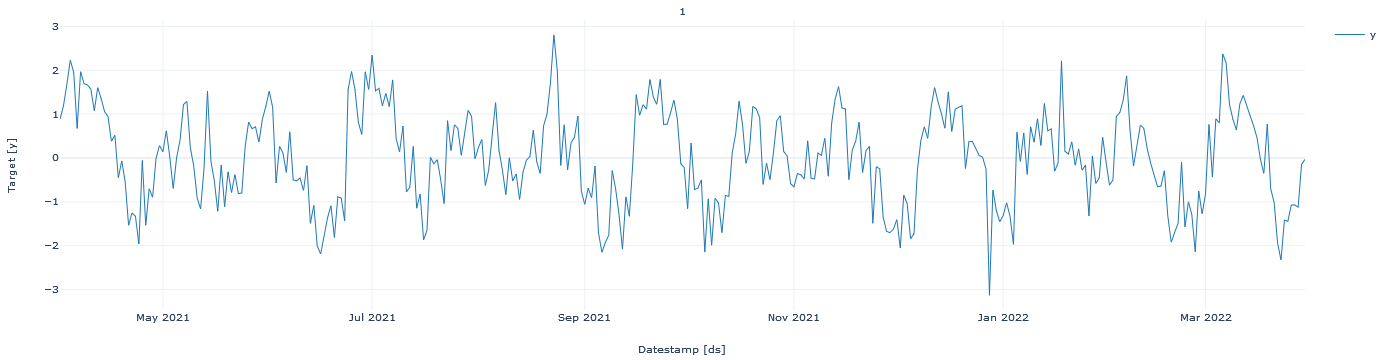

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = (15,4)
StatsForecast.plot(df, engine='plotly')

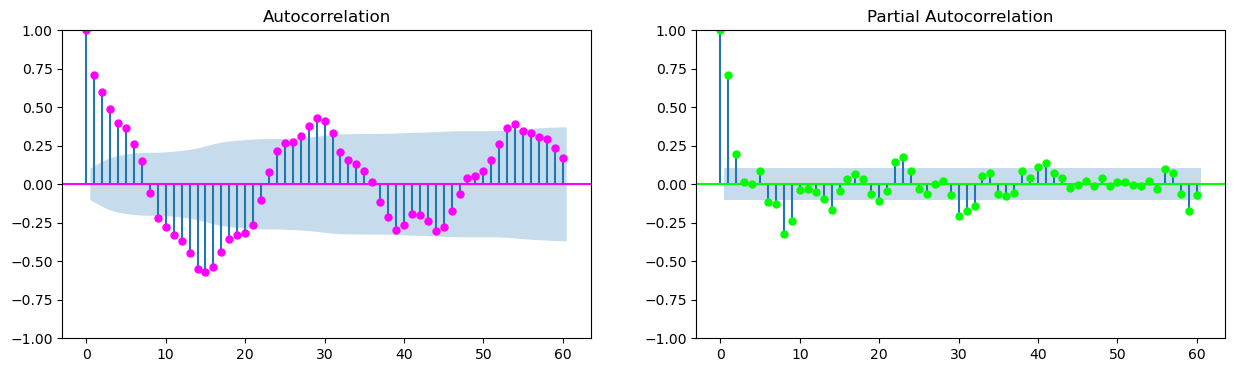

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=60, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

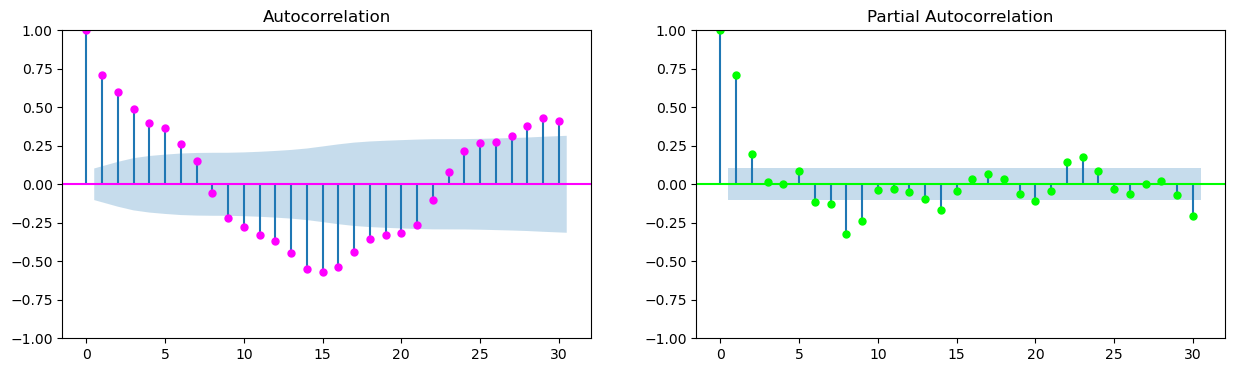

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

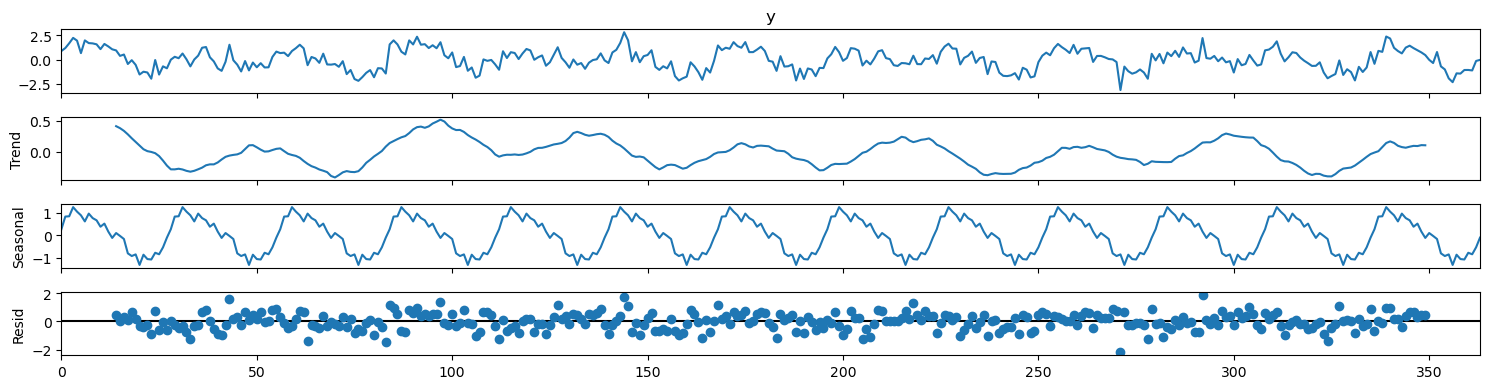

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "additive", period=28)
a.plot();


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotSeasonalDecompose(
    x,
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0,
    title="Seasonal Decomposition"):

    result = seasonal_decompose(
            x, model=model, filt=filt, period=period,
            two_sided=two_sided, extrapolate_trend=extrapolate_trend)
    fig = make_subplots(
            rows=4, cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"])
    for idx, col in enumerate(['observed', 'trend', 'seasonal', 'resid']):
        fig.add_trace(
            go.Scatter(x=result.observed.index, y=getattr(result, col), mode='lines'),
                row=idx+1, col=1,
            )
    return fig


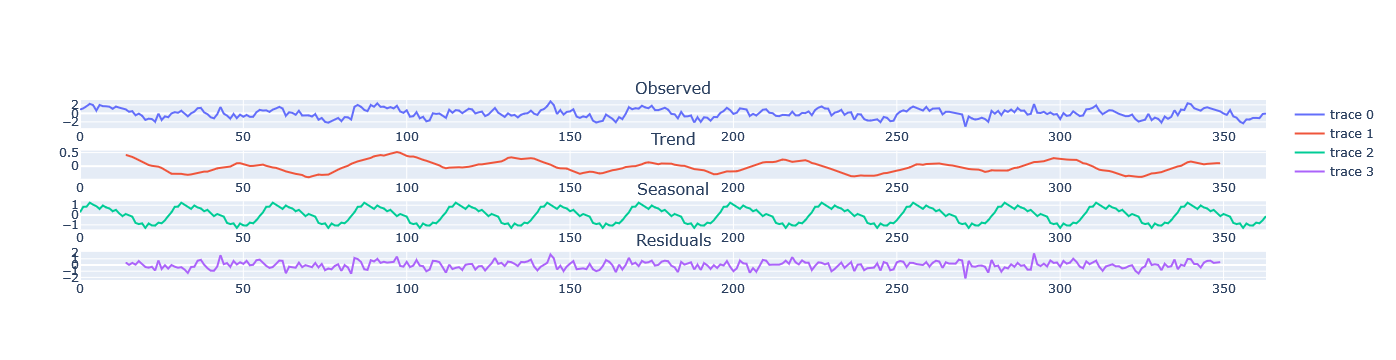

In [ ]:
plotSeasonalDecompose(
    df["y"],
    model="additive",
    period=28,
    title="Seasonal Decomposition")

In [ ]:
horizon = 28 * 2

train_size = weeks * resolution - horizon
train, test = df[:train_size], df[train_size:]


df.shape, train.shape, test.shape

((364, 3), (308, 3), (56, 3))

## Create Model

In [ ]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from utilsforecast.plotting import plot_series

In [ ]:
# Import the necessary models from various libraries

# LGBMRegressor: A gradient boosting framework that uses tree-based learning algorithms from the LightGBM library
from lightgbm import LGBMRegressor

# XGBRegressor: A gradient boosting regressor model from the XGBoost library
from xgboost import XGBRegressor

# LinearRegression: A simple linear regression model from the scikit-learn library
from sklearn.linear_model import LinearRegression


In [ ]:
# Instantiate the MLForecast object
params = {
    "verbosity": -5
}

mlf = MLForecast(
    models=[LGBMRegressor(**params), XGBRegressor(), LinearRegression()],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
    freq='D',  # Frequency of the data - 'D' for daily frequency
    lags=list(range(1, 28)),  # Specific lags to use as regressors: 1 to 6 days
    lag_transforms={
        1: [expanding_mean],
        3: [expanding_mean],
        5: [expanding_mean],
        14: [(rolling_mean, 28)],
        7: [(rolling_mean, 14)],
        3: [(rolling_mean, 7)],
        
    },

    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],  # Date features to use as regressors
    num_threads=10,
)


In [ ]:
prep = mlf.preprocess(train, dropna=True)
prep.loc[1:'y']

,y,unique_id,ds,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,rolling_mean_lag3_window_size7,expanding_mean_lag5,rolling_mean_lag14_window_size28,rolling_mean_lag7_window_size14,year,month,day,dayofweek,quarter,week
41,-1.163704,1,2021-05-12,-0.912752,-0.188616,0.234450,1.291528,1.216687,0.407324,0.006757,...,0.354921,0.380462,0.431463,-0.526721,2021,5,12,2,2,19
42,-0.227256,1,2021-05-13,-1.163704,-0.912752,-0.188616,0.234450,1.291528,1.216687,0.407324,...,0.323695,0.404438,0.399534,-0.408213,2021,5,13,3,2,19
43,1.526975,1,2021-05-14,-0.227256,-1.163704,-0.912752,-0.188616,0.234450,1.291528,1.216687,...,0.293626,0.400079,0.367424,-0.226265,2021,5,14,4,2,19
44,-0.071539,1,2021-05-15,1.526975,-0.227256,-1.163704,-0.912752,-0.188616,0.234450,1.291528,...,0.126417,0.385362,0.312378,0.006824,2021,5,15,5,2,19
45,-0.525568,1,2021-05-16,-0.071539,1.526975,-0.227256,-1.163704,-0.912752,-0.188616,0.234450,...,0.035763,0.353700,0.254907,0.027002,2021,5,16,6,2,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,-0.454238,1,2022-01-29,-0.585046,0.049184,-1.333844,-0.160548,-0.284042,0.207878,-0.171845,...,-0.182921,0.041598,-0.135169,0.501497,2022,1,29,5,1,4
304,0.476971,1,2022-01-30,-0.454238,-0.585046,0.049184,-1.333844,-0.160548,-0.284042,0.207878,...,-0.188547,0.040925,-0.187325,0.464957,2022,1,30,6,1,4
305,-0.097651,1,2022-01-31,0.476971,-0.454238,-0.585046,0.049184,-1.333844,-0.160548,-0.284042,...,-0.325466,0.036357,-0.233925,0.419495,2022,1,31,0,1,5
306,-0.622777,1,2022-02-01,-0.097651,0.476971,-0.454238,-0.585046,0.049184,-1.333844,-0.160548,...,-0.365808,0.036400,-0.146023,0.343701,2022,2,1,1,1,5


In [ ]:
from time import time
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(train, prediction_intervals=PredictionIntervals(h=horizon, n_windows=2))

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


MLForecast Minutes: 0.06610998709996542


In [ ]:
fcst_mlf_df = mlf.predict(horizon,
                          #level=[90]
                         )

In [ ]:
fcst_mlf_df.head()

,unique_id,ds,LGBMRegressor,XGBRegressor,LinearRegression
0,1,2022-02-03,0.165059,0.862316,-0.109627
1,1,2022-02-04,0.375490,1.042413,-0.017544
2,1,2022-02-05,0.352139,1.294334,0.300877
3,1,2022-02-06,1.063436,1.249144,0.506214
4,1,2022-02-07,0.508790,1.422384,0.301202


In [ ]:
fcst_mlf_df_plot = long_form(fcst_mlf_df)
fcst_mlf_df_plot

,ds,unique_id,price
0,2022-02-03,unique_id,1.000000
1,2022-02-04,unique_id,1.000000
2,2022-02-05,unique_id,1.000000
3,2022-02-06,unique_id,1.000000
4,2022-02-07,unique_id,1.000000
...,...,...,...
219,2022-03-26,LinearRegression,-0.143730
220,2022-03-27,LinearRegression,0.035111
221,2022-03-28,LinearRegression,-0.211611
222,2022-03-29,LinearRegression,-0.210740


In [ ]:
df_test = df_plot.query("unique_id == 'final'")[int(-horizon*1.5):]
df_test

,ds,unique_id,price
280,2022-01-06,final,-0.085467
281,2022-01-07,final,0.576483
282,2022-01-08,final,-0.385228
283,2022-01-09,final,0.719438
284,2022-01-10,final,0.352424
...,...,...,...
359,2022-03-26,final,-1.075326
360,2022-03-27,final,-1.071706
361,2022-03-28,final,-1.120472
362,2022-03-29,final,-0.144448


In [ ]:
fcst_mlf_df_plot = pd.concat([fcst_mlf_df_plot,df_test])

In [ ]:
fcst_mlf_df_plot

,ds,unique_id,price
0,2022-02-03,unique_id,1.0
1,2022-02-04,unique_id,1.0
2,2022-02-05,unique_id,1.0
3,2022-02-06,unique_id,1.0
4,2022-02-07,unique_id,1.0
...,...,...,...
359,2022-03-26,final,-1.075326
360,2022-03-27,final,-1.071706
361,2022-03-28,final,-1.120472
362,2022-03-29,final,-0.144448


In [ ]:
altair_plot(fcst_mlf_df_plot)

alt.LayerChart(...)

## Cross Validate

In [ ]:
init = time()
cv_mlf_df = mlf.cross_validation(
    df=train, 
    h=horizon, 
    n_windows=4, 
    step_size=horizon, 
    level=[90],
)
end = time()
print(f'CV Minutes: {(end - init) / 60}')

CV Minutes: 0.09884265661239625


In [ ]:
cv_mlf_df.head()

,unique_id,ds,cutoff,y,LGBMRegressor,XGBRegressor,LinearRegression
0,1,2021-06-24,2021-06-23,1.557940,-0.703467,0.046745,13.555471
1,1,2021-06-25,2021-06-23,1.977053,-0.616080,0.147216,-14.964685
2,1,2021-06-26,2021-06-23,1.558700,-0.647443,0.149506,10.710260
3,1,2021-06-27,2021-06-23,0.807387,-0.139943,0.204176,-0.959143
4,1,2021-06-28,2021-06-23,0.529640,0.160516,0.203331,-5.428722


In [ ]:
cv_mlf_df.drop('cutoff', axis=1, inplace=True)
cv_mlf_df.drop('LinearRegression', axis=1, inplace=True)
cv_mlf_df.drop('unique_id', axis=1, inplace=True)

In [ ]:
cv_mlf_df = long_form(cv_mlf_df)

In [ ]:
altair_plot(cv_mlf_df)

alt.LayerChart(...)

## Performance

In [ ]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)

In [ ]:
fcst_mlf_df.info(), fcst_mlf_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         56 non-null     int64         
 1   ds                56 non-null     datetime64[ns]
 2   LGBMRegressor     56 non-null     float64       
 3   XGBRegressor      56 non-null     float32       
 4   LinearRegression  56 non-null     float64       
dtypes: datetime64[ns](1), float32(1), float64(2), int64(1)
memory usage: 2.1 KB


(None,
 Index(['unique_id', 'ds', 'LGBMRegressor', 'XGBRegressor', 'LinearRegression'], dtype='object'))

In [ ]:
def evaluate_performace(y_hist, y_true, y_pred):
    #y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    print(y_pred.columns)
    for i, model in enumerate(y_pred.columns):
        if i < 2: continue
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                    y_pred[model].values, 
                                                    y_hist['y'].values, seasonality=12)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_pred[model].values)
    return pd.DataFrame(evaluation)


In [ ]:
train.columns, test.columns

(Index(['y', 'unique_id', 'ds'], dtype='object'),
 Index(['y', 'unique_id', 'ds'], dtype='object'))

In [ ]:
evaluate_performace(train, test, fcst_mlf_df).style.background_gradient(cmap ='YlGn', axis = 1,low=0.5, high=0.6)

Index(['unique_id', 'ds', 'LGBMRegressor', 'XGBRegressor', 'LinearRegression'], dtype='object')


,LGBMRegressor,XGBRegressor,LinearRegression
mase,0.405929,0.574238,0.607204
mae,0.581893,0.823161,0.870418
mape,127.363073,204.620876,122.106361
rmse,0.724010,0.963238,1.026189
smape,92.922506,115.879716,145.479426


In [ ]:
results = evaluate_performace(train, test, fcst_mlf_df)
results.to_csv('Data/ML_results2.1.csv')

Index(['unique_id', 'ds', 'LGBMRegressor', 'XGBRegressor', 'LinearRegression'], dtype='object')
